In [110]:
import pandas as pd
from datetime import datetime

import yfinance as yf

import warnings
warnings.filterwarnings("ignore")

In [111]:
# portfolio of stocks

# NASDAQ Composite (^IXIC)
# Dow Jones Industrial Average (^DJI)
# S&P 500 (^GSPC)
# Russell 2000 Index (^RUT)

stocks = ['^IXIC', '^DJI', '^GSPC', '^RUT']

In [112]:
# Calculate dates properly
end_date = datetime.now()
start_date = end_date - pd.DateOffset(years=10)

# Convert to strings for yfinance if needed (yfinance accepts datetime objects too)
print(f"Date range: {start_date.strftime('%Y-%m-%d')} to {end_date.strftime('%Y-%m-%d')}")

# Download historical data from yf API
df = yf.download(stocks, start=start_date, end=end_date, group_by='ticker', interval='1d')

# # download data to csv
# df.to_csv("indexes_data.csv")

# Load the CSV with MultiIndex columns (Tickers, OHLCV)
df = pd.read_csv("indexes_data.csv", header=[0,1], index_col=0)

# Drop any rows that are completely NaN (e.g. 'Date' row)
df = df.dropna(how='all')

# Convert all values to float
df = df.astype(float)

# rename level 0 of the columns MultiIndex (the tickers)
df.columns = df.columns.set_levels([ticker.replace('^IXIC', 'NASDAQ').replace('^DJI', 'DOWJONES').replace('^GSPC', 'SP500').replace('^RUT', 'RUSSELL2000') for ticker in df.columns.levels[0]], level=0)

# Show the result
df.head()

Date range: 2015-09-11 to 2025-09-11


[*********************100%***********************]  4 of 4 completed



Ticker            SP500                                                       \
Price              Open         High          Low        Close        Volume   
Date                                                                           
2015-09-11  1951.449951  1961.050049  1939.189941  1961.050049  3.218590e+09   
2015-09-14  1963.060059  1963.060059  1948.270020  1953.030029  3.000200e+09   
2015-09-15  1955.099976  1983.189941  1954.300049  1978.089966  3.239860e+09   
2015-09-16  1978.020020  1997.260010  1977.930054  1995.310059  3.630680e+09   
2015-09-17  1995.329956  2020.859985  1986.729980  1990.199951  4.183790e+09   

Ticker           NASDAQ                                                       \
Price              Open         High          Low        Close        Volume   
Date                                                                           
2015-09-11  4770.729980  4822.339844  4763.149902  4822.339844  1.686190e+09   
2015-09-14  4831.979980  4832.000000  4791.080078  4805.759766  1.467740e+09   
2015-09-15  4819.319824  4872.350098  4802.089844  4860.520020  1.587460e+09   
2015-09-16  4860.430176  4893.439941  4848.149902  4889.240234  1.666380e+09   
2015-09-17  4884.109863  4960.870117  4880.500000  4893.950195  1.891510e+09   

Ticker          DOWJONES                                            \
Price               Open          High           Low         Close   
Date                                                                 
2015-09-11  16330.400391  16434.759766  16244.650391  16433.089844   
2015-09-14  16450.859375  16450.859375  16330.870117  16370.959961   
2015-09-15  16382.580078  16644.109375  16382.580078  16599.849609   
2015-09-16  16599.509766  16755.980469  16593.900391  16739.949219   
2015-09-17  16738.080078  16933.429688  16639.929688  16674.740234   

Ticker                   RUSSELL2000                                         \
Price            Volume         Open         High          Low        Close   
Date                                                                          
2015-09-11  104630000.0  1152.510010  1157.910034  1143.729980  1157.790039   
2015-09-14   92660000.0  1158.030029  1159.170044  1151.310059  1153.500000   
2015-09-15   93050000.0  1153.930054  1167.280029  1153.930054  1166.000000   
2015-09-16   99620000.0  1166.170044  1175.890015  1165.410034  1175.199951   
2015-09-17  129600000.0  1175.089966  1193.989990  1173.699951  1180.689941   

Ticker                    
Price             Volume  
Date                      
2015-09-11  3.218590e+09  
2015-09-14  3.000200e+09  
2015-09-15  3.239860e+09  
2015-09-16  3.630680e+09  
2015-09-17  4.183790e+09

In [113]:
sp500 = df['SP500']

# keep only the 'Open' and 'Close' columns
sp500 = sp500[['Open', 'Close']]

# sp500.columns lowercase
sp500.columns = [col.lower() for col in sp500.columns]

# index to datetime
sp500.index = pd.to_datetime(sp500.index)

print("SP500 data preview:")
sp500.head()

SP500 data preview:


,open,close
Date,,
2015-09-11,1951.449951,1961.050049
2015-09-14,1963.060059,1953.030029
2015-09-15,1955.099976,1978.089966
2015-09-16,1978.020020,1995.310059
2015-09-17,1995.329956,1990.199951


In [114]:
# Create dataframes for all indices
def prepare_index_data(df, index_name):
    """Helper function to prepare index data"""
    index_df = df[index_name]
    
    # keep only the 'Open' and 'Close' columns
    index_df = index_df[['Open', 'Close']]
    
    # columns lowercase
    index_df.columns = [col.lower() for col in index_df.columns]
    
    # index to datetime
    index_df.index = pd.to_datetime(index_df.index)
    
    # add column 'day_of_week' with the day of the week (0=Monday, 6=Sunday)
    index_df['day_of_week'] = index_df.index.weekday
    
    # calculate the gap percentage
    index_df['gap_pct'] = ((index_df['open'] - index_df['close'].shift(1)) / index_df['close'].shift(1)) * 100
    
    gap_threshold = 0.5  # 0.5%
    # Label the gaps: Gap Up (1), Gap Down (-1), No Gap (0)
    def label_gap(gap):
        if gap > gap_threshold:
            return 1  # Gap Up
        elif gap < -gap_threshold:
            return -1  # Gap Down
        else:
            return 0  # No Gap
    
    # drop na
    index_df = index_df.dropna()
    
    index_df['gap_label'] = index_df['gap_pct'].apply(label_gap)
    
    return index_df

# Create all index dataframes
sp500 = prepare_index_data(df, 'SP500')
nasdaq = prepare_index_data(df, 'NASDAQ')
dowjones = prepare_index_data(df, 'DOWJONES')
russell2000 = prepare_index_data(df, 'RUSSELL2000')

print("Dataframes created for:")
print(f"SP500: {len(sp500)} records")
print(f"NASDAQ: {len(nasdaq)} records") 
print(f"Dow Jones: {len(dowjones)} records")
print(f"Russell 2000: {len(russell2000)} records")

Dataframes created for:
SP500: 2513 records
NASDAQ: 2513 records
Dow Jones: 2513 records
Russell 2000: 2513 records


In [115]:
# add column 'day_of_week' with the day of the week (0=Monday, 6=Sunday)
sp500['day_of_week'] = sp500.index.weekday

In [116]:
# calculate the gap percentage
sp500['gap_pct'] = ((sp500['open'] - sp500['close'].shift(1)) / sp500['close'].shift(1)) * 100

gap_threshold = 0.5  # 0.5%
# Label the gaps: Gap Up (1), Gap Down (-1), No Gap (0)
def label_gap(gap):
    if gap > gap_threshold:  # Customize threshold
        return 1  # Gap Up
    elif gap < -gap_threshold:
        return -1  # Gap Down
    else:
        return 0  # No Gap

# drop na
sp500 = sp500.dropna()

sp500['gap_label'] = sp500['gap_pct'].apply(label_gap)

In [117]:
sp500.head()

,open,close,day_of_week,gap_pct,gap_label
Date,,,,,
2015-09-15,1955.099976,1978.089966,1,0.105986,0
2015-09-16,1978.020020,1995.310059,2,-0.003536,0
2015-09-17,1995.329956,1990.199951,3,0.000997,0
2015-09-18,1989.660034,1958.030029,4,-0.027129,0
2015-09-21,1960.839966,1966.969971,0,0.143508,0


In [118]:
# count gap_label
sp500['gap_label'].value_counts()

gap_label
 0    2054
 1     243
-1     215
Name: count, dtype: int64

In [119]:
"""
entry strategy (LONG only):
group by day_of_week, gap_label == 1, entry at open (market), exit at close of the same day
"""

# Filter for gap up days only (gap_label == 1)
gap_up_days = sp500[sp500['gap_label'] == 1].copy()

# Calculate intraday return: (close - open) / open * 100
gap_up_days['intraday_return'] = ((gap_up_days['close'] - gap_up_days['open']) / gap_up_days['open']) * 100

# Group by day of the week and calculate statistics
day_names = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

strategy_results = gap_up_days.groupby('day_of_week')['intraday_return'].agg([
    'count',    # Number of gap up days
    'mean',     # Average return
    'std',      # Standard deviation
    'min',      # Worst return
    'max',      # Best return
    'sum'       # Total return
]).round(4)

# Add day names for better readability
strategy_results.index = [day_names[i] for i in strategy_results.index]

print("Gap Up Trading Strategy Results by Day of Week")
print("=" * 60)
print(strategy_results)

# Calculate win rate for each day
win_rates = gap_up_days.groupby('day_of_week').apply(
    lambda x: (x['intraday_return'] > 0).sum() / len(x) * 100
).round(2)
win_rates.index = [day_names[i] for i in win_rates.index]

print("\nWin Rate by Day of Week:")
print("-" * 30)
for day, rate in win_rates.items():
    print(f"{day}: {rate}%")

# Overall strategy performance
total_trades = len(gap_up_days)
total_return = gap_up_days['intraday_return'].sum()
avg_return = gap_up_days['intraday_return'].mean()
win_rate = (gap_up_days['intraday_return'] > 0).sum() / total_trades * 100

print(f"\nOverall Strategy Performance:")
print("-" * 30)
print(f"Total Gap Up Days: {total_trades}")
print(f"Total Return: {total_return:.2f}%")
print(f"Average Return per Trade: {avg_return:.4f}%")
print(f"Overall Win Rate: {win_rate:.2f}%")


Gap Up Trading Strategy Results by Day of Week
           count    mean     std     min     max      sum
Monday        53  0.4711  1.0507 -1.7059  3.8984  24.9668
Tuesday       55  0.3377  1.3926 -4.0589  4.3887  18.5753
Wednesday     47  0.4709  1.1109 -1.9505  4.4255  22.1315
Thursday      45  0.1702  1.2102 -2.1276  5.1485   7.6584
Friday        43  0.3422  1.5185 -5.2230  5.4876  14.7134

Win Rate by Day of Week:
------------------------------
Monday: 71.7%
Tuesday: 61.82%
Wednesday: 74.47%
Thursday: 57.78%
Friday: 74.42%

Overall Strategy Performance:
------------------------------
Total Gap Up Days: 243
Total Return: 88.05%
Average Return per Trade: 0.3623%
Overall Win Rate: 67.90%


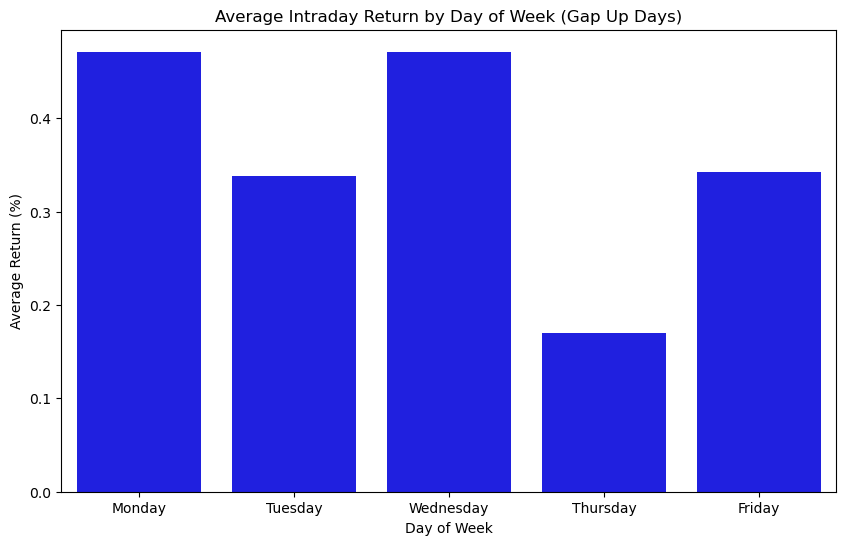

In [120]:
# plot results
import matplotlib.pyplot as plt
import seaborn as sns

# Bar plot for average returns by day of the week
plt.figure(figsize=(10, 6))
sns.barplot(x=strategy_results.index, y=strategy_results['mean'], color='blue')
plt.title("Average Intraday Return by Day of Week (Gap Up Days)")
plt.xlabel("Day of Week")
plt.ylabel("Average Return (%)")
# plt.axhline(0, color='red', linestyle='--')
plt.show()

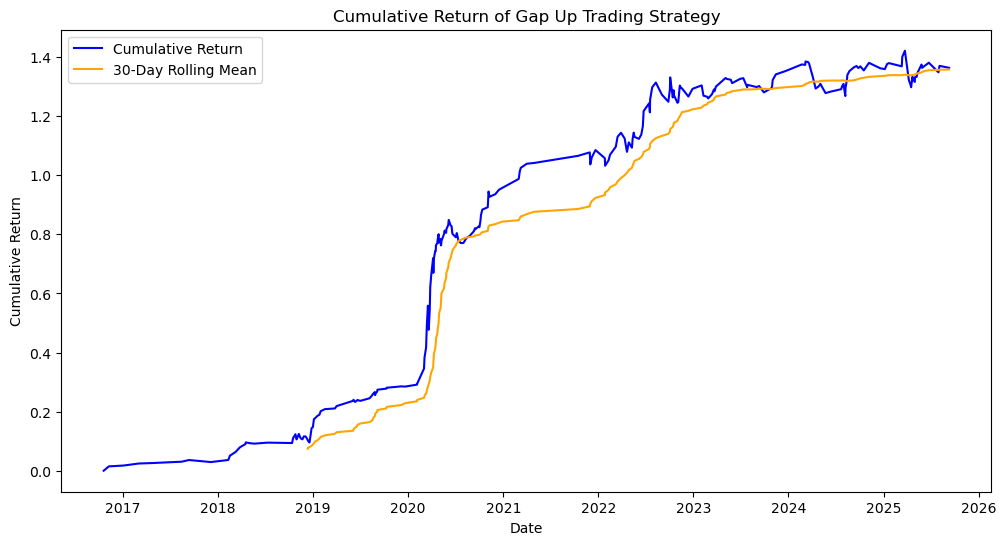

In [121]:
# plot rolling cumulative return
gap_up_days['cumulative_return'] = (1 + gap_up_days['intraday_return'] / 100).cumprod() - 1
gap_up_days['rolling_cumulative_return'] = gap_up_days['cumulative_return'].rolling(window=30).mean()

plt.figure(figsize=(12, 6))
plt.plot(gap_up_days.index, gap_up_days['cumulative_return'], label='Cumulative Return', color='blue')
plt.plot(gap_up_days.index, gap_up_days['rolling_cumulative_return'], label='30-Day Rolling Mean', color='orange')
plt.title("Cumulative Return of Gap Up Trading Strategy")   
plt.xlabel("Date")
plt.ylabel("Cumulative Return")
plt.legend()
plt.show()

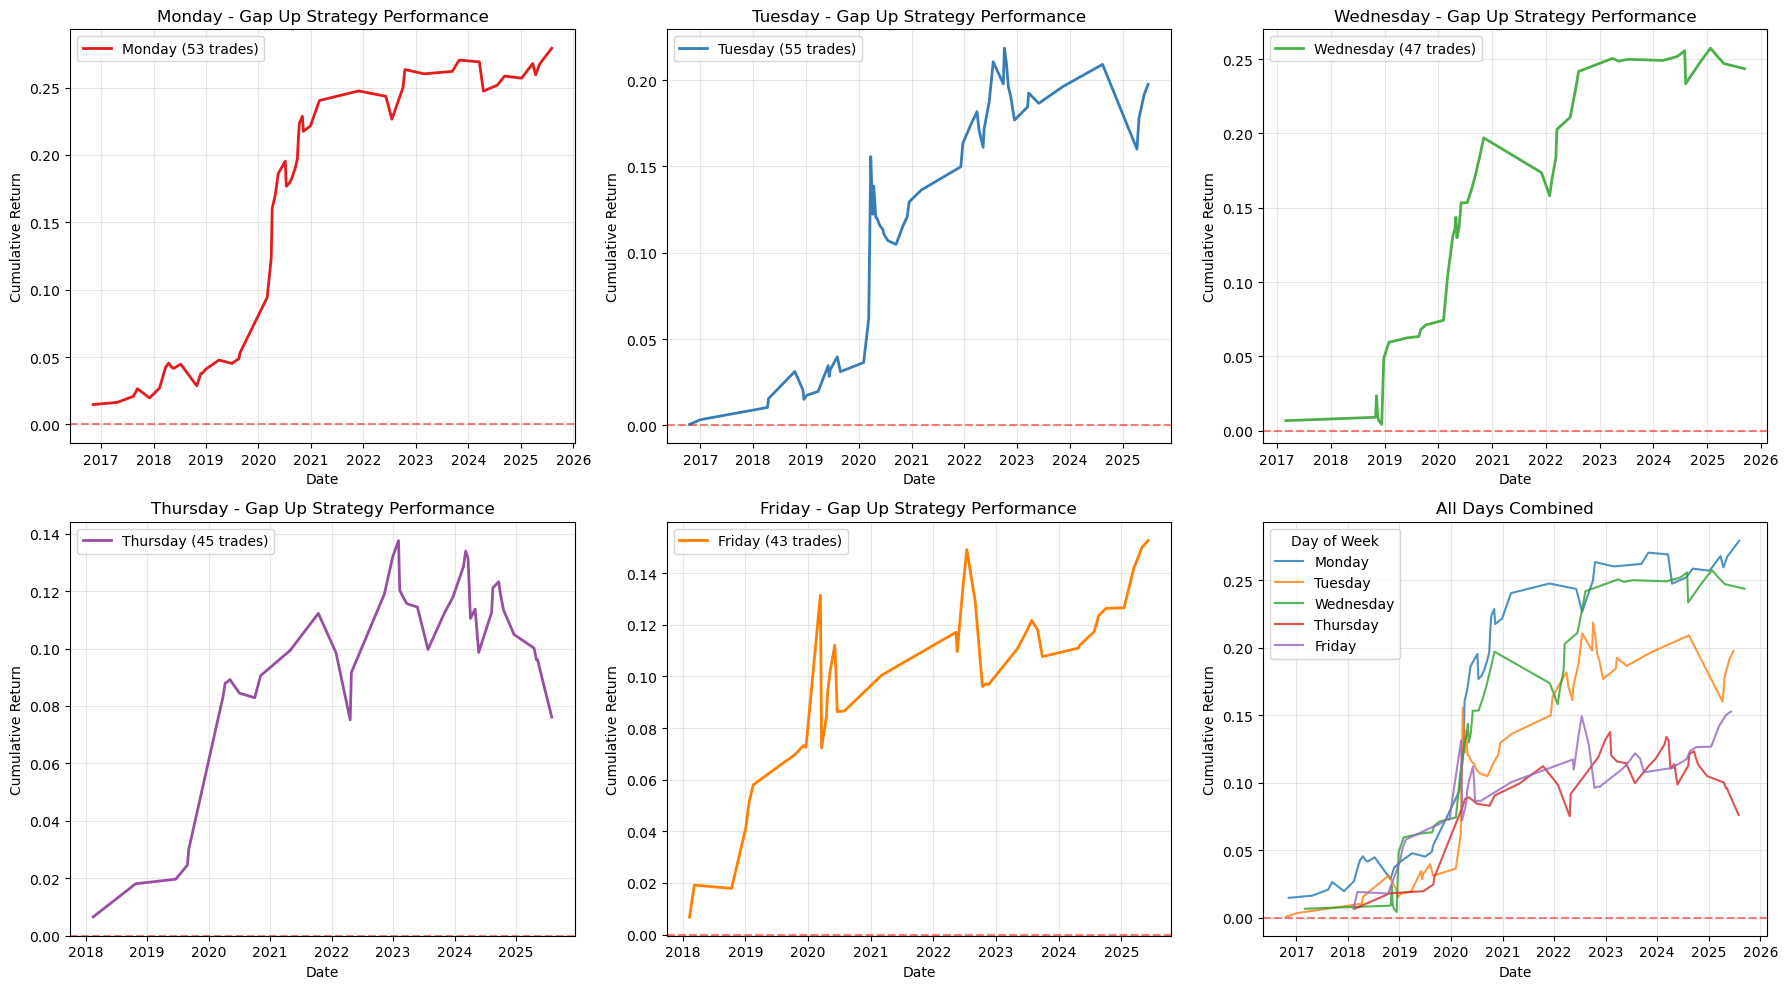

In [122]:
# plot rolling cumulative return for each day of the week
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

# Create individual subplot for each day of the week
for day in range(5):  # Monday to Friday
    day_data = gap_up_days[gap_up_days['day_of_week'] == day]
    if not day_data.empty:
        # Calculate separate cumulative return for this day only
        day_cumulative = (1 + day_data['intraday_return'] / 100).cumprod() - 1
        
        axes[day].plot(day_data.index, day_cumulative, 
                      label=f'{day_names[day]} ({len(day_data)} trades)', 
                      linewidth=2, color=plt.cm.Set1(day))
        axes[day].set_title(f'{day_names[day]} - Gap Up Strategy Performance')
        axes[day].set_xlabel('Date')
        axes[day].set_ylabel('Cumulative Return')
        axes[day].legend()
        axes[day].grid(True, alpha=0.3)
        axes[day].axhline(0, color='red', linestyle='--', alpha=0.5)

# Combined plot in the last subplot
axes[5].set_title('All Days Combined')
for day in range(5):  # Monday to Friday
    day_data = gap_up_days[gap_up_days['day_of_week'] == day]
    if not day_data.empty:
        day_cumulative = (1 + day_data['intraday_return'] / 100).cumprod() - 1
        axes[5].plot(day_data.index, day_cumulative, 
                    label=f'{day_names[day]}', linewidth=1.5, alpha=0.8)

axes[5].set_xlabel('Date')
axes[5].set_ylabel('Cumulative Return')
axes[5].legend(title="Day of Week")
axes[5].grid(True, alpha=0.3)
axes[5].axhline(0, color='red', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

In [123]:
# Comprehensive analysis function for all indices
def analyze_gap_strategy(index_df, index_name):
    """Analyze gap trading strategy for any index"""
    
    # Filter for gap up days only (gap_label == 1)
    gap_up_days = index_df[index_df['gap_label'] == 1].copy()
    
    if len(gap_up_days) == 0:
        return None, None, None
    
    # Calculate intraday return: (close - open) / open * 100
    gap_up_days['intraday_return'] = ((gap_up_days['close'] - gap_up_days['open']) / gap_up_days['open']) * 100
    
    # Group by day of the week and calculate statistics
    day_names = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    
    strategy_results = gap_up_days.groupby('day_of_week')['intraday_return'].agg([
        'count',    # Number of gap up days
        'mean',     # Average return
        'std',      # Standard deviation
        'min',      # Worst return
        'max',      # Best return
        'sum'       # Total return
    ]).round(4)
    
    # Add day names for better readability
    strategy_results.index = [day_names[i] for i in strategy_results.index]
    
    # Calculate win rate for each day
    win_rates = gap_up_days.groupby('day_of_week').apply(
        lambda x: (x['intraday_return'] > 0).sum() / len(x) * 100
    ).round(2)
    win_rates.index = [day_names[i] for i in win_rates.index]
    
    # Overall strategy performance
    total_trades = len(gap_up_days)
    total_return = gap_up_days['intraday_return'].sum()
    avg_return = gap_up_days['intraday_return'].mean()
    win_rate = (gap_up_days['intraday_return'] > 0).sum() / total_trades * 100
    
    # Summary statistics
    summary = {
        'Index': index_name,
        'Total Gap Up Days': total_trades,
        'Total Return (%)': round(total_return, 2),
        'Average Return per Trade (%)': round(avg_return, 4),
        'Overall Win Rate (%)': round(win_rate, 2),
        'Best Day (Avg Return)': strategy_results['mean'].idxmax(),
        'Best Day Return (%)': round(strategy_results['mean'].max(), 4),
        'Worst Day (Avg Return)': strategy_results['mean'].idxmin(),
        'Worst Day Return (%)': round(strategy_results['mean'].min(), 4)
    }
    
    return strategy_results, win_rates, summary

# Analyze all indices
indices = {
    'SP500': sp500,
    'NASDAQ': nasdaq, 
    'Dow Jones': dowjones,
    'Russell 2000': russell2000
}

all_results = {}
all_summaries = []

print("Gap Trading Strategy Analysis for All Indices")
print("=" * 80)

for name, data in indices.items():
    print(f"\n{name.upper()} ANALYSIS:")
    print("-" * 50)
    
    results, win_rates, summary = analyze_gap_strategy(data, name)
    
    if results is not None:
        all_results[name] = {
            'strategy_results': results,
            'win_rates': win_rates,
            'summary': summary
        }
        all_summaries.append(summary)
        
        print(f"Total Gap Up Days: {summary['Total Gap Up Days']}")
        print(f"Total Return: {summary['Total Return (%)']}%")
        print(f"Average Return per Trade: {summary['Average Return per Trade (%)']}%") 
        print(f"Overall Win Rate: {summary['Overall Win Rate (%)']}%")
        print(f"Best Day: {summary['Best Day (Avg Return)']} ({summary['Best Day Return (%)']}%)")
        print(f"Worst Day: {summary['Worst Day (Avg Return)']} ({summary['Worst Day Return (%)']}%)")
    else:
        print(f"No gap up days found for {name}")

Gap Trading Strategy Analysis for All Indices

SP500 ANALYSIS:
--------------------------------------------------
Total Gap Up Days: 243
Total Return: 88.05%
Average Return per Trade: 0.3623%
Overall Win Rate: 67.9%
Best Day: Monday (0.4711%)
Worst Day: Thursday (0.1702%)

NASDAQ ANALYSIS:
--------------------------------------------------
Total Gap Up Days: 527
Total Return: 27.8%
Average Return per Trade: 0.0528%
Overall Win Rate: 58.82%
Best Day: Wednesday (0.1159%)
Worst Day: Thursday (0.0036%)

DOW JONES ANALYSIS:
--------------------------------------------------
Total Gap Up Days: 170
Total Return: 68.01%
Average Return per Trade: 0.4001%
Overall Win Rate: 67.65%
Best Day: Monday (0.7265%)
Worst Day: Tuesday (0.2195%)

RUSSELL 2000 ANALYSIS:
--------------------------------------------------
Total Gap Up Days: 179
Total Return: 100.32%
Average Return per Trade: 0.5605%
Overall Win Rate: 63.69%
Best Day: Tuesday (0.8118%)
Worst Day: Friday (0.3036%)



COMPARATIVE SUMMARY - ALL INDICES
              Total Gap Up Days  Total Return (%)  \
Index                                               
SP500                       243             88.05   
NASDAQ                      527             27.80   
Dow Jones                   170             68.01   
Russell 2000                179            100.32   

              Average Return per Trade (%)  Overall Win Rate (%)  \
Index                                                              
SP500                               0.3623                 67.90   
NASDAQ                              0.0528                 58.82   
Dow Jones                           0.4001                 67.65   
Russell 2000                        0.5605                 63.69   

             Best Day (Avg Return)  Best Day Return (%)  \
Index                                                     
SP500                       Monday               0.4711   
NASDAQ                   Wednesday               0.1159   
D

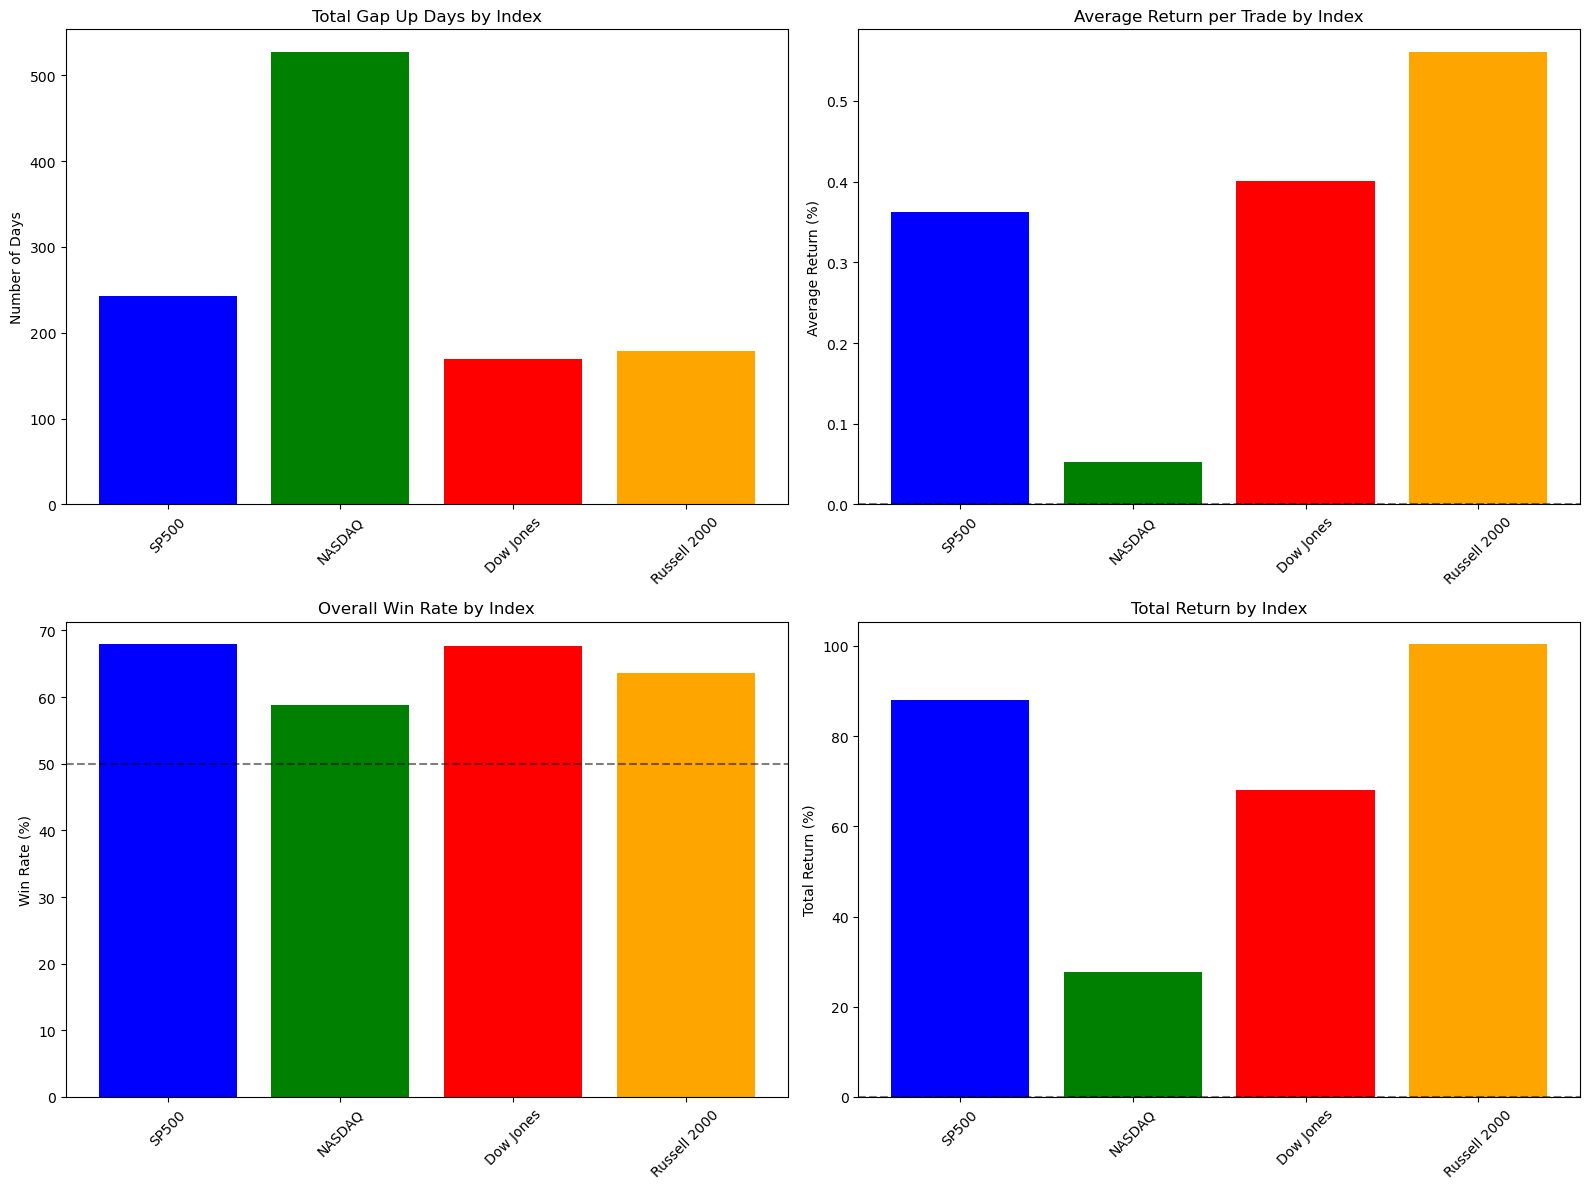


🏆 PERFORMANCE RANKINGS:
--------------------------------------------------
Best Average Return per Trade: Russell 2000 (0.5605%)
Best Win Rate: SP500 (67.9%)
Best Total Return: Russell 2000 (100.32%)
Most Trading Opportunities: NASDAQ (527 days)
Best Risk-Adjusted Performance: Russell 2000

📊 STRATEGY INSIGHTS:
--------------------------------------------------
• Average gap opportunities per index: 280 days
• Most consistent performer (highest win rate): SP500
• Highest return potential: Russell 2000
• Market with most gap opportunities: NASDAQ


In [124]:
# Create comprehensive summary comparison
summary_df = pd.DataFrame(all_summaries)
summary_df = summary_df.set_index('Index')

print("\n" + "=" * 100)
print("COMPARATIVE SUMMARY - ALL INDICES")
print("=" * 100)
print(summary_df)

# Visualization comparing all indices
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Total Gap Up Days comparison
axes[0,0].bar(summary_df.index, summary_df['Total Gap Up Days'], color=['blue', 'green', 'red', 'orange'])
axes[0,0].set_title('Total Gap Up Days by Index')
axes[0,0].set_ylabel('Number of Days')
axes[0,0].tick_params(axis='x', rotation=45)

# 2. Average Return per Trade comparison
axes[0,1].bar(summary_df.index, summary_df['Average Return per Trade (%)'], color=['blue', 'green', 'red', 'orange'])
axes[0,1].set_title('Average Return per Trade by Index')
axes[0,1].set_ylabel('Average Return (%)')
axes[0,1].tick_params(axis='x', rotation=45)
axes[0,1].axhline(0, color='black', linestyle='--', alpha=0.5)

# 3. Win Rate comparison
axes[1,0].bar(summary_df.index, summary_df['Overall Win Rate (%)'], color=['blue', 'green', 'red', 'orange'])
axes[1,0].set_title('Overall Win Rate by Index')
axes[1,0].set_ylabel('Win Rate (%)')
axes[1,0].tick_params(axis='x', rotation=45)
axes[1,0].axhline(50, color='black', linestyle='--', alpha=0.5, label='50% threshold')

# 4. Total Return comparison
axes[1,1].bar(summary_df.index, summary_df['Total Return (%)'], color=['blue', 'green', 'red', 'orange'])
axes[1,1].set_title('Total Return by Index')
axes[1,1].set_ylabel('Total Return (%)')
axes[1,1].tick_params(axis='x', rotation=45)
axes[1,1].axhline(0, color='black', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

# Best performing index analysis
best_avg_return = summary_df['Average Return per Trade (%)'].idxmax()
best_win_rate = summary_df['Overall Win Rate (%)'].idxmax()
best_total_return = summary_df['Total Return (%)'].idxmax()
most_opportunities = summary_df['Total Gap Up Days'].idxmax()

print(f"\n🏆 PERFORMANCE RANKINGS:")
print("-" * 50)
print(f"Best Average Return per Trade: {best_avg_return} ({summary_df.loc[best_avg_return, 'Average Return per Trade (%)']}%)")
print(f"Best Win Rate: {best_win_rate} ({summary_df.loc[best_win_rate, 'Overall Win Rate (%)']}%)")
print(f"Best Total Return: {best_total_return} ({summary_df.loc[best_total_return, 'Total Return (%)']}%)")
print(f"Most Trading Opportunities: {most_opportunities} ({summary_df.loc[most_opportunities, 'Total Gap Up Days']} days)")

# Risk-adjusted performance (Sharpe-like ratio)
summary_df['Risk_Adj_Performance'] = summary_df['Average Return per Trade (%)'] / (summary_df['Average Return per Trade (%)'].std() if summary_df['Average Return per Trade (%)'].std() > 0 else 1)
best_risk_adj = summary_df['Risk_Adj_Performance'].idxmax()
print(f"Best Risk-Adjusted Performance: {best_risk_adj}")

print(f"\n📊 STRATEGY INSIGHTS:")
print("-" * 50)
print(f"• Average gap opportunities per index: {summary_df['Total Gap Up Days'].mean():.0f} days")
print(f"• Most consistent performer (highest win rate): {best_win_rate}")
print(f"• Highest return potential: {best_avg_return}")
print(f"• Market with most gap opportunities: {most_opportunities}")

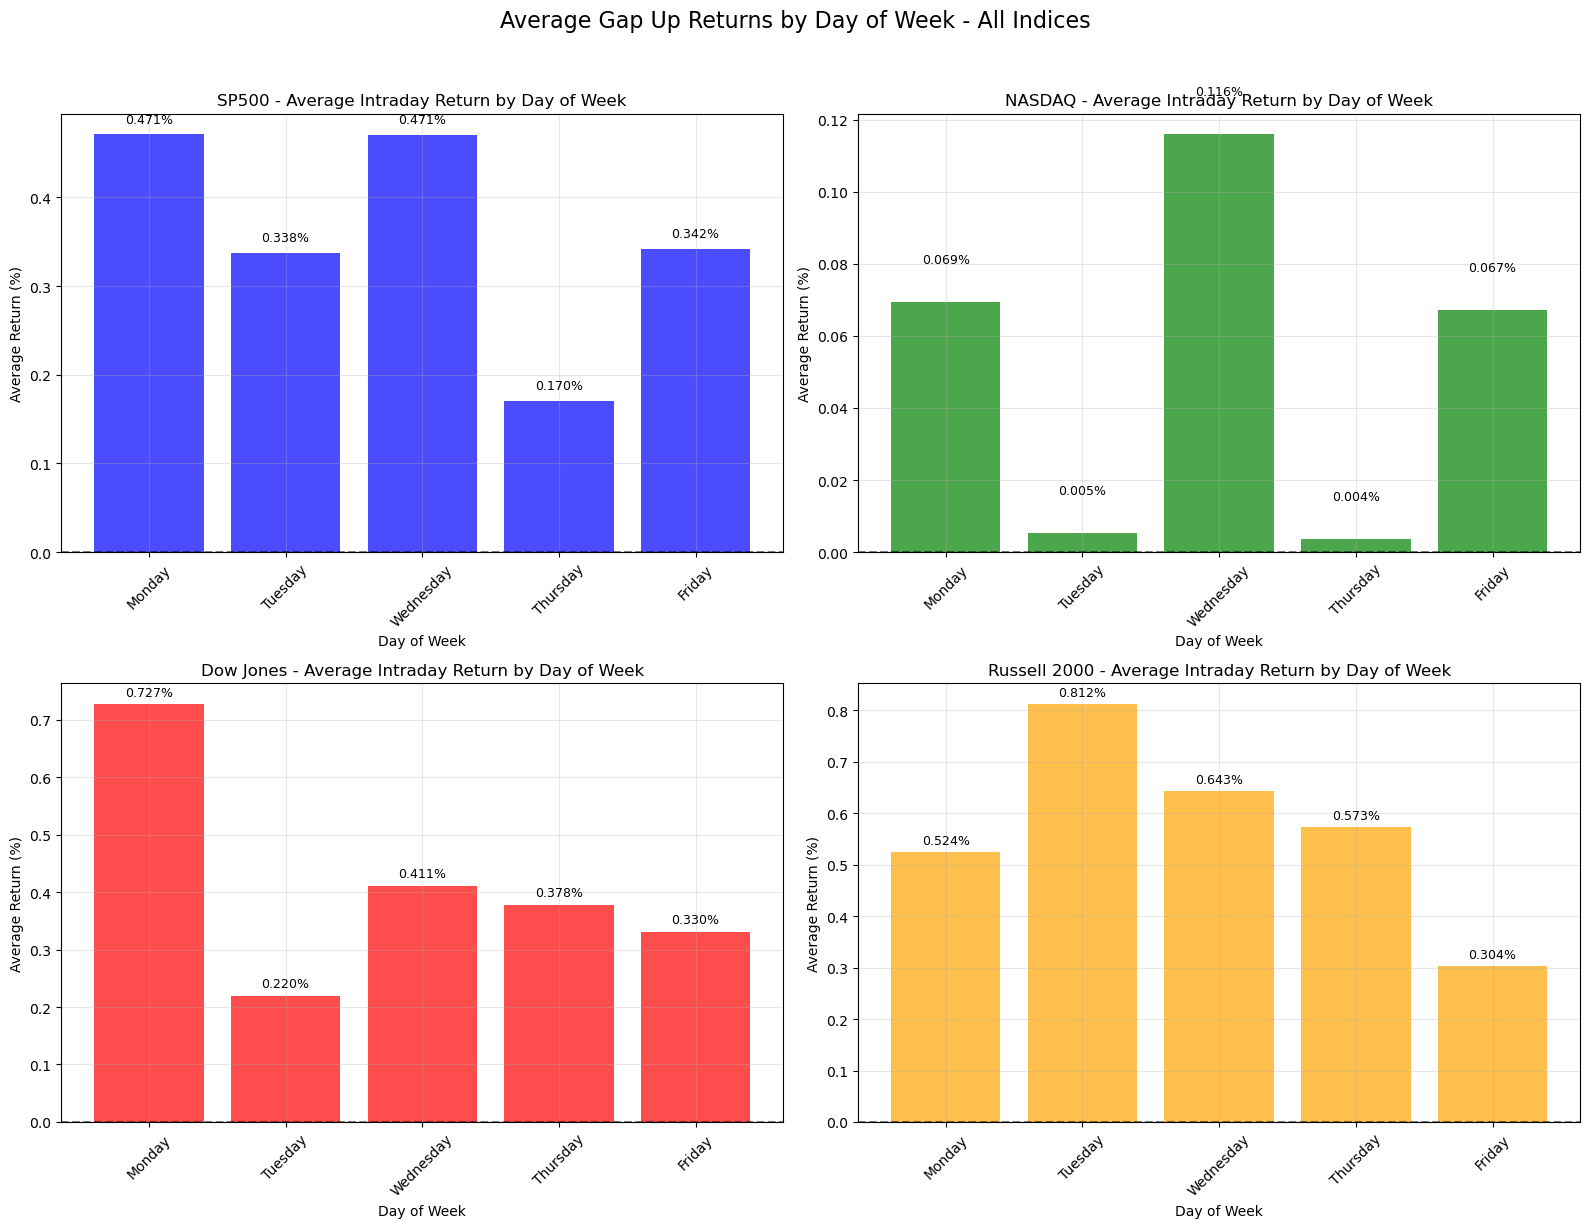

In [125]:
# Plot average returns by day of week for all indices
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

# Colors for each index
colors = ['blue', 'green', 'red', 'orange']
index_names = ['SP500', 'NASDAQ', 'Dow Jones', 'Russell 2000']

for i, (name, data) in enumerate(indices.items()):
    if name in all_results:
        strategy_results = all_results[name]['strategy_results']
        
        axes[i].bar(strategy_results.index, strategy_results['mean'], 
                   color=colors[i], alpha=0.7)
        axes[i].set_title(f"{index_names[i]} - Average Intraday Return by Day of Week")
        axes[i].set_xlabel("Day of Week")
        axes[i].set_ylabel("Average Return (%)")
        axes[i].tick_params(axis='x', rotation=45)
        axes[i].axhline(0, color='black', linestyle='--', alpha=0.5)
        axes[i].grid(True, alpha=0.3)
        
        # Add value labels on bars
        for j, v in enumerate(strategy_results['mean']):
            axes[i].text(j, v + 0.01 if v >= 0 else v - 0.02, f'{v:.3f}%', 
                        ha='center', va='bottom' if v >= 0 else 'top', fontsize=9)

plt.suptitle("Average Gap Up Returns by Day of Week - All Indices", fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

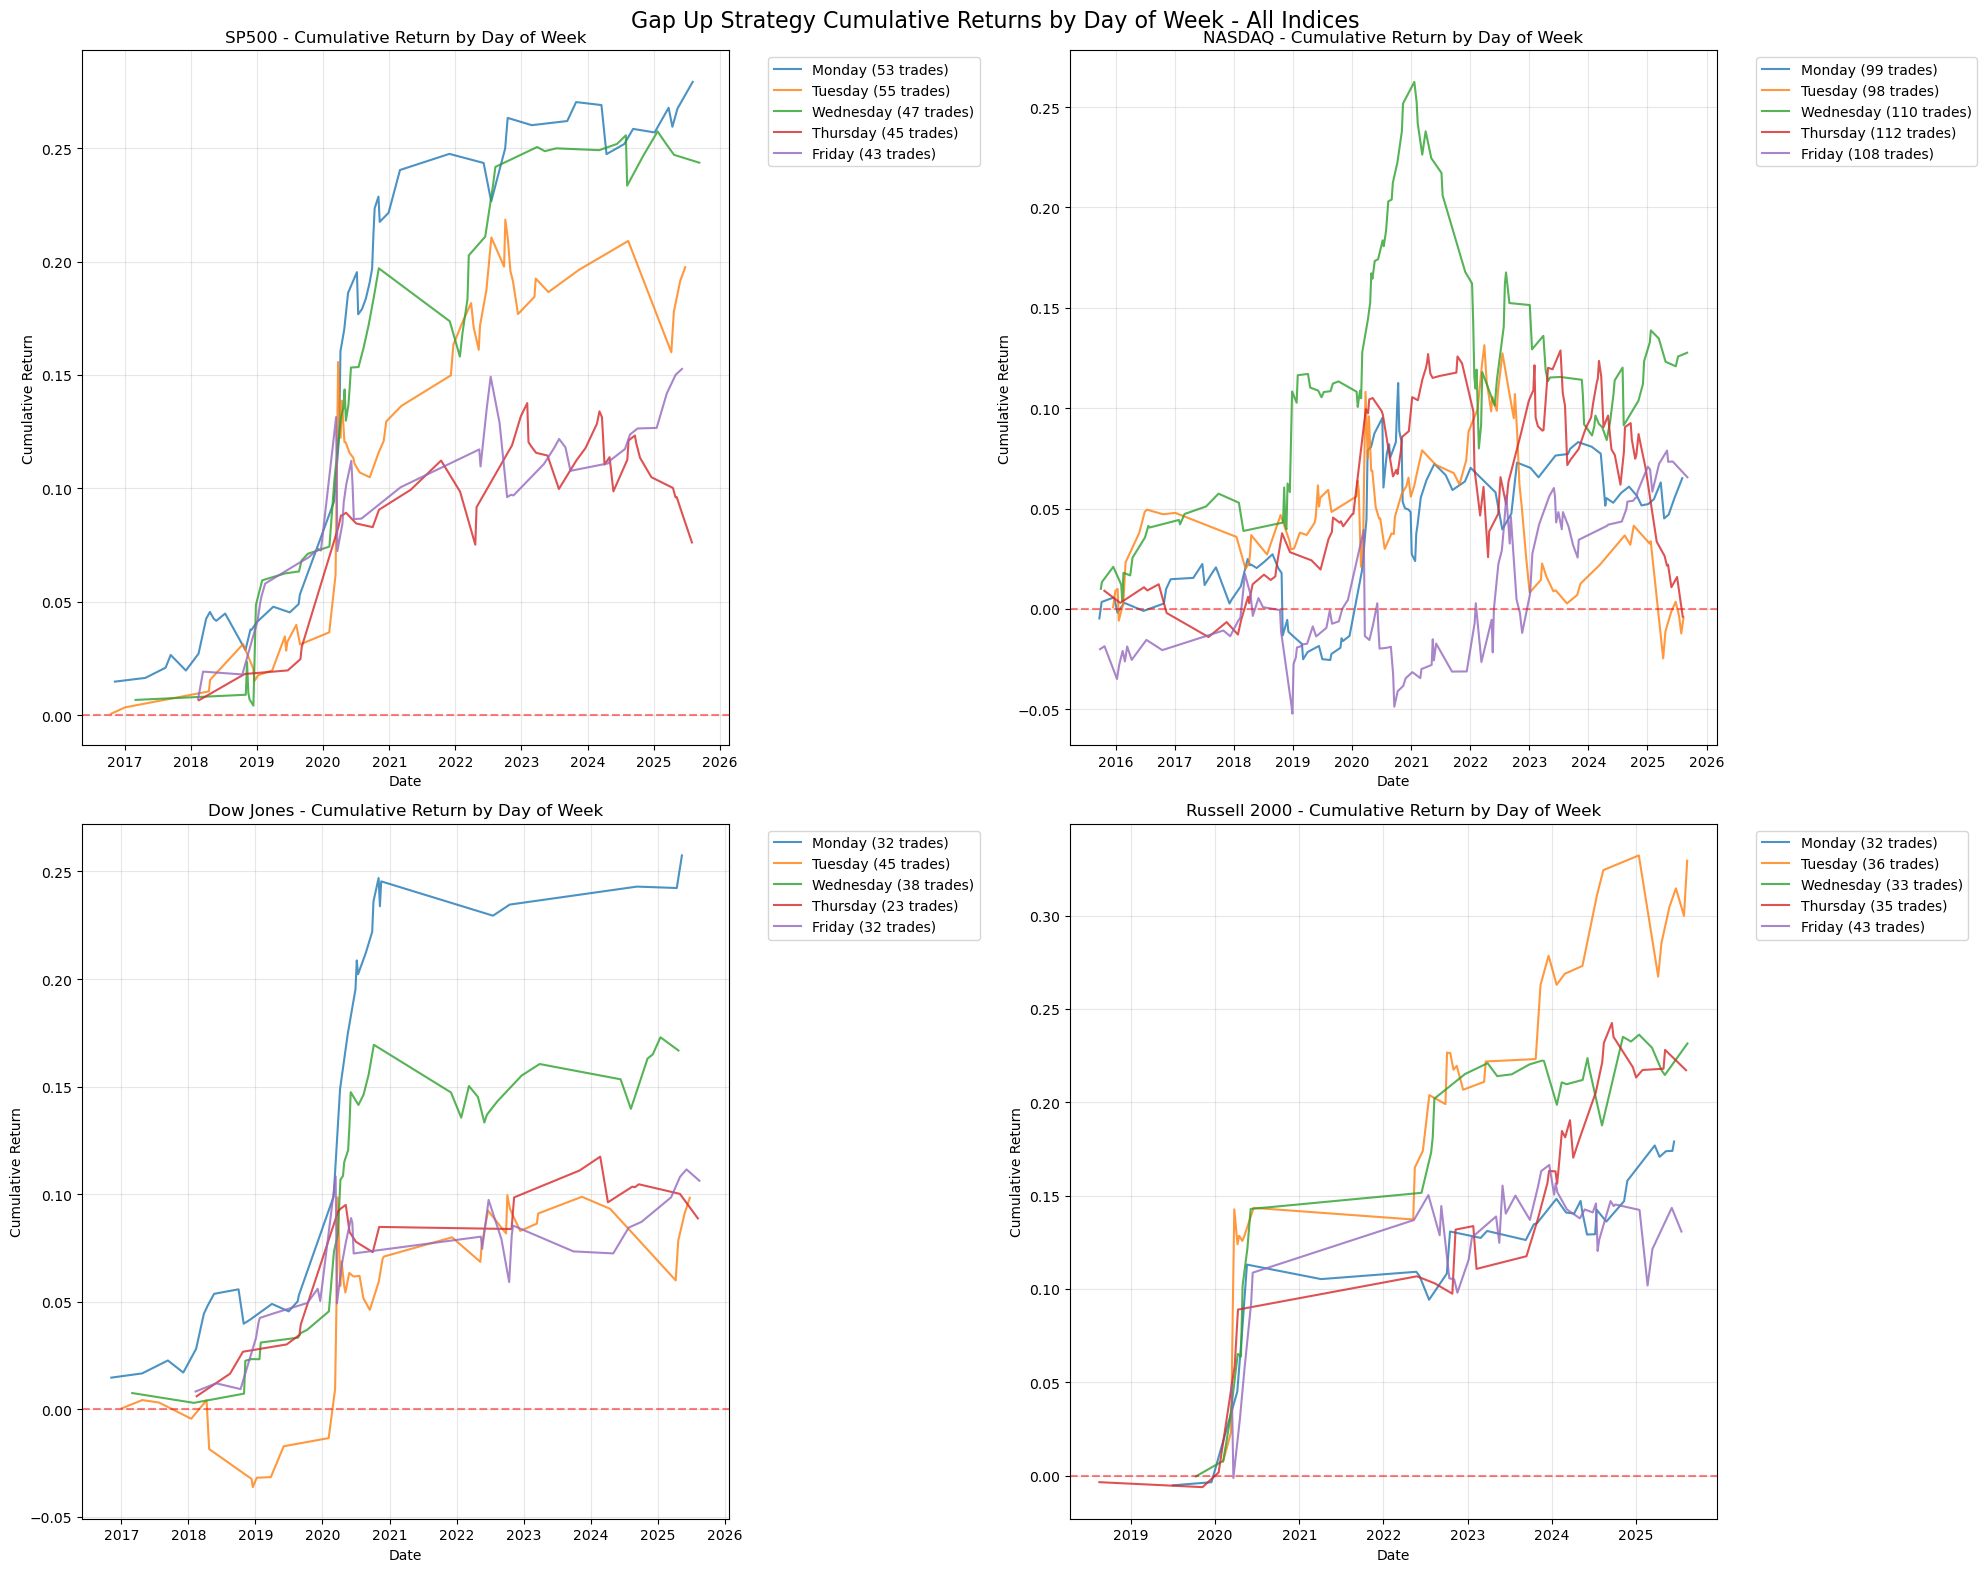

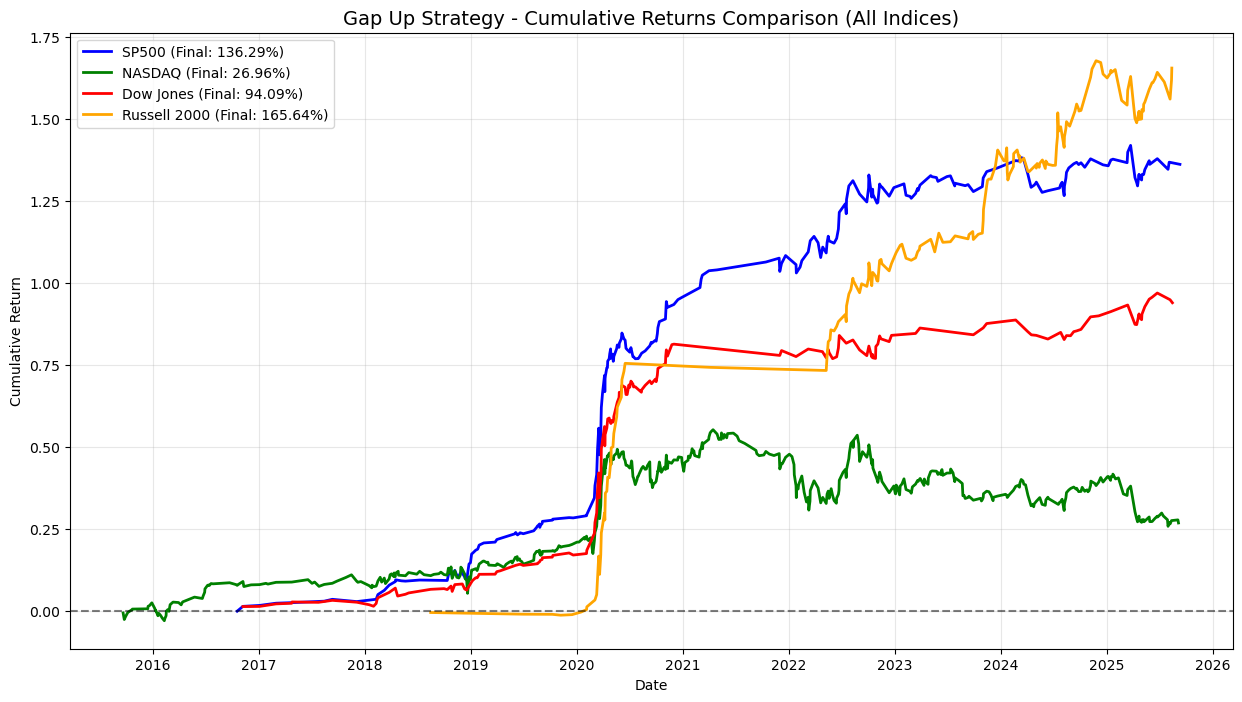

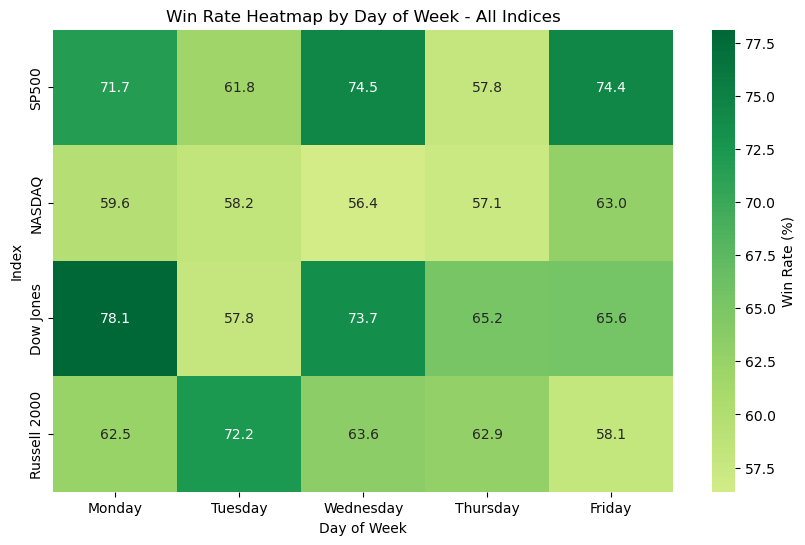

In [126]:
# Cumulative return plots for all indices
fig, axes = plt.subplots(2, 2, figsize=(20, 16))
axes = axes.flatten()

day_names = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
colors = ['blue', 'green', 'red', 'orange']
index_names = ['SP500', 'NASDAQ', 'Dow Jones', 'Russell 2000']

for i, (name, data) in enumerate(indices.items()):
    # Filter for gap up days
    gap_up_days_index = data[data['gap_label'] == 1].copy()
    
    if not gap_up_days_index.empty:
        # Calculate intraday return
        gap_up_days_index['intraday_return'] = ((gap_up_days_index['close'] - gap_up_days_index['open']) / gap_up_days_index['open']) * 100
        
        # Plot cumulative return for each day of the week
        for day in range(5):  # Monday to Friday
            day_data = gap_up_days_index[gap_up_days_index['day_of_week'] == day]
            if not day_data.empty:
                day_cumulative = (1 + day_data['intraday_return'] / 100).cumprod() - 1
                axes[i].plot(day_data.index, day_cumulative, 
                           label=f'{day_names[day]} ({len(day_data)} trades)', 
                           linewidth=1.5, alpha=0.8)
        
        axes[i].set_title(f'{index_names[i]} - Cumulative Return by Day of Week')
        axes[i].set_xlabel('Date')
        axes[i].set_ylabel('Cumulative Return')
        axes[i].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        axes[i].grid(True, alpha=0.3)
        axes[i].axhline(0, color='red', linestyle='--', alpha=0.5)

plt.suptitle("Gap Up Strategy Cumulative Returns by Day of Week - All Indices", fontsize=16, y=0.98)
plt.tight_layout()
plt.show()

# Overall cumulative comparison across all indices
plt.figure(figsize=(15, 8))

for i, (name, data) in enumerate(indices.items()):
    gap_up_days_index = data[data['gap_label'] == 1].copy()
    
    if not gap_up_days_index.empty:
        gap_up_days_index['intraday_return'] = ((gap_up_days_index['close'] - gap_up_days_index['open']) / gap_up_days_index['open']) * 100
        cumulative_return = (1 + gap_up_days_index['intraday_return'] / 100).cumprod() - 1
        
        plt.plot(gap_up_days_index.index, cumulative_return, 
                label=f'{index_names[i]} (Final: {cumulative_return.iloc[-1]:.2%})', 
                linewidth=2, color=colors[i])

plt.title("Gap Up Strategy - Cumulative Returns Comparison (All Indices)", fontsize=14)
plt.xlabel("Date")
plt.ylabel("Cumulative Return")
plt.legend()
plt.grid(True, alpha=0.3)
plt.axhline(0, color='black', linestyle='--', alpha=0.5)
plt.show()

# Win rate comparison heatmap
win_rate_data = []
for name, data in indices.items():
    if name in all_results:
        win_rates = all_results[name]['win_rates']
        win_rate_data.append([win_rates.get(day, 0) for day in day_names[:5]])  # Monday to Friday only

win_rate_df = pd.DataFrame(win_rate_data, 
                          index=index_names, 
                          columns=day_names[:5])

plt.figure(figsize=(10, 6))
sns.heatmap(win_rate_df, annot=True, cmap='RdYlGn', center=50, 
            fmt='.1f', cbar_kws={'label': 'Win Rate (%)'})
plt.title("Win Rate Heatmap by Day of Week - All Indices")
plt.xlabel("Day of Week")
plt.ylabel("Index")
plt.show()

In [129]:
"""
add here cumulative return plots for all indices
"""

'\nadd here cumulative return plots for all indices\n'

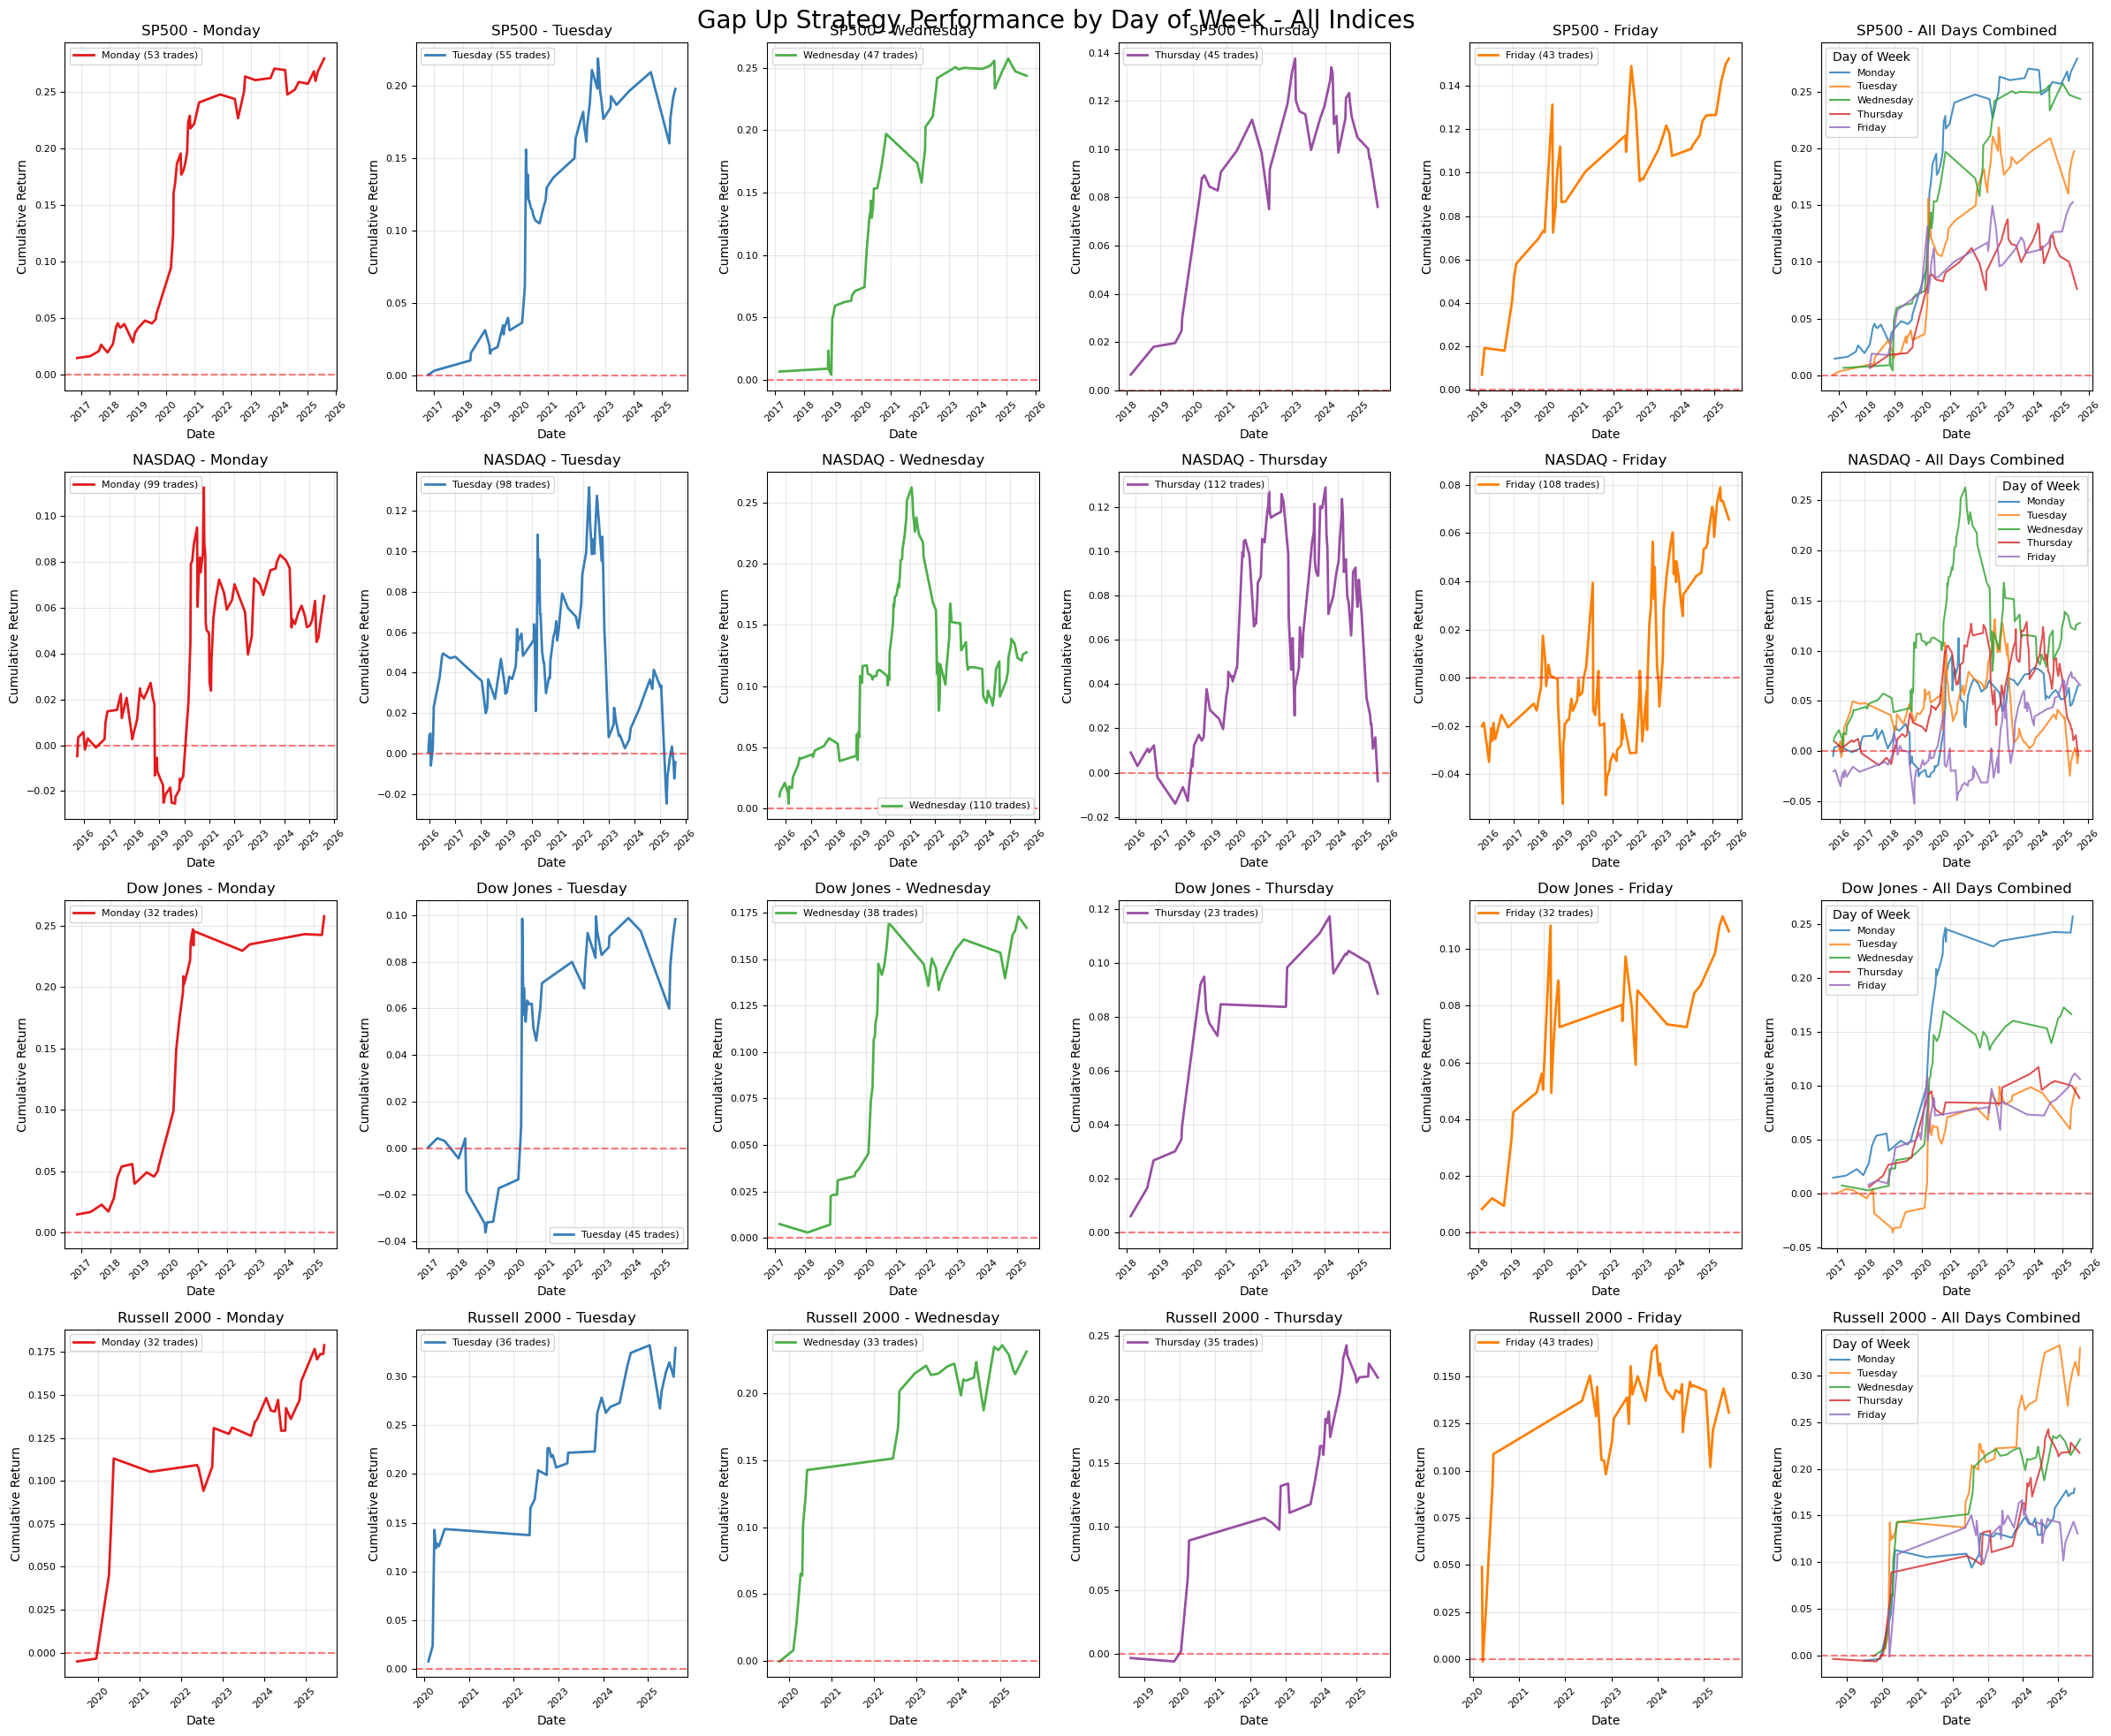


DETAILED PERFORMANCE BY INDEX AND DAY OF WEEK
       Index       Day  Trades  Avg_Return_%  Total_Return_%  Win_Rate_%  Best_Return_%  Worst_Return_%  Std_Dev_%
       SP500    Monday      53        0.4711           24.97       71.70         3.8984         -1.7059     1.0507
       SP500   Tuesday      55        0.3377           18.58       61.82         4.3887         -4.0589     1.3926
       SP500 Wednesday      47        0.4709           22.13       74.47         4.4255         -1.9505     1.1109
       SP500  Thursday      45        0.1702            7.66       57.78         5.1485         -2.1276     1.2102
       SP500    Friday      43        0.3422           14.71       74.42         5.4876         -5.2230     1.5185
      NASDAQ    Monday      99        0.0694            6.87       59.60         3.3037         -3.1601     1.0695
      NASDAQ   Tuesday      98        0.0052            0.51       58.16         3.7158         -5.6432     1.3797
      NASDAQ Wednesday     110   

In [127]:
# Comprehensive day-of-week analysis for each index (similar to cell 13 structure)
day_names = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
index_names = ['SP500', 'NASDAQ', 'Dow Jones', 'Russell 2000']

# Create a large figure with subplots for each index
fig = plt.figure(figsize=(24, 20))

# Counter for subplot positioning
subplot_counter = 1

for idx, (name, data) in enumerate(indices.items()):
    # Filter for gap up days for this index
    gap_up_days_index = data[data['gap_label'] == 1].copy()
    
    if not gap_up_days_index.empty:
        # Calculate intraday return
        gap_up_days_index['intraday_return'] = ((gap_up_days_index['close'] - gap_up_days_index['open']) / gap_up_days_index['open']) * 100
        
        # Create 2x3 subplots for each index (5 weekdays + 1 combined)
        for day in range(6):  # 0-4 for weekdays, 5 for combined
            ax = plt.subplot(4, 6, subplot_counter)
            
            if day < 5:  # Individual weekdays
                day_data = gap_up_days_index[gap_up_days_index['day_of_week'] == day]
                if not day_data.empty:
                    # Calculate separate cumulative return for this day only
                    day_cumulative = (1 + day_data['intraday_return'] / 100).cumprod() - 1
                    
                    ax.plot(day_data.index, day_cumulative, 
                           label=f'{day_names[day]} ({len(day_data)} trades)', 
                           linewidth=2, color=plt.cm.Set1(day))
                    ax.set_title(f'{index_names[idx]} - {day_names[day]}')
                    ax.set_xlabel('Date')
                    ax.set_ylabel('Cumulative Return')
                    ax.legend(fontsize=8)
                    ax.grid(True, alpha=0.3)
                    ax.axhline(0, color='red', linestyle='--', alpha=0.5)
                    
                    # Format x-axis for better readability
                    ax.tick_params(axis='x', rotation=45, labelsize=8)
                    ax.tick_params(axis='y', labelsize=8)
                else:
                    ax.text(0.5, 0.5, f'No {day_names[day]}\ngap-up days', 
                           ha='center', va='center', transform=ax.transAxes)
                    ax.set_title(f'{index_names[idx]} - {day_names[day]}')
            
            else:  # Combined plot (day == 5)
                ax.set_title(f'{index_names[idx]} - All Days Combined')
                for weekday in range(5):  # Monday to Friday
                    day_data = gap_up_days_index[gap_up_days_index['day_of_week'] == weekday]
                    if not day_data.empty:
                        day_cumulative = (1 + day_data['intraday_return'] / 100).cumprod() - 1
                        ax.plot(day_data.index, day_cumulative, 
                               label=f'{day_names[weekday]}', linewidth=1.5, alpha=0.8)
                
                ax.set_xlabel('Date')
                ax.set_ylabel('Cumulative Return')
                ax.legend(title="Day of Week", fontsize=8)
                ax.grid(True, alpha=0.3)
                ax.axhline(0, color='red', linestyle='--', alpha=0.5)
                ax.tick_params(axis='x', rotation=45, labelsize=8)
                ax.tick_params(axis='y', labelsize=8)
            
            subplot_counter += 1

plt.suptitle("Gap Up Strategy Performance by Day of Week - All Indices", fontsize=20, y=0.98)
plt.tight_layout()
plt.show()

# Summary statistics table for each index and day combination
print("\n" + "=" * 120)
print("DETAILED PERFORMANCE BY INDEX AND DAY OF WEEK")
print("=" * 120)

summary_table = []
for name, data in indices.items():
    gap_up_days_index = data[data['gap_label'] == 1].copy()
    
    if not gap_up_days_index.empty:
        gap_up_days_index['intraday_return'] = ((gap_up_days_index['close'] - gap_up_days_index['open']) / gap_up_days_index['open']) * 100
        
        for day in range(5):  # Monday to Friday
            day_data = gap_up_days_index[gap_up_days_index['day_of_week'] == day]
            if not day_data.empty:
                day_stats = {
                    'Index': name,
                    'Day': day_names[day],
                    'Trades': len(day_data),
                    'Avg_Return_%': round(day_data['intraday_return'].mean(), 4),
                    'Total_Return_%': round(day_data['intraday_return'].sum(), 2),
                    'Win_Rate_%': round((day_data['intraday_return'] > 0).sum() / len(day_data) * 100, 2),
                    'Best_Return_%': round(day_data['intraday_return'].max(), 4),
                    'Worst_Return_%': round(day_data['intraday_return'].min(), 4),
                    'Std_Dev_%': round(day_data['intraday_return'].std(), 4)
                }
                summary_table.append(day_stats)

detailed_df = pd.DataFrame(summary_table)
print(detailed_df.to_string(index=False))

# Find best performing day-index combinations
print(f"\n🏆 BEST PERFORMING COMBINATIONS:")
print("-" * 60)
best_avg = detailed_df.loc[detailed_df['Avg_Return_%'].idxmax()]
best_total = detailed_df.loc[detailed_df['Total_Return_%'].idxmax()]
best_winrate = detailed_df.loc[detailed_df['Win_Rate_%'].idxmax()]
most_trades = detailed_df.loc[detailed_df['Trades'].idxmax()]

print(f"Best Average Return: {best_avg['Index']} on {best_avg['Day']} ({best_avg['Avg_Return_%']}%)")
print(f"Best Total Return: {best_total['Index']} on {best_total['Day']} ({best_total['Total_Return_%']}%)")
print(f"Best Win Rate: {best_winrate['Index']} on {best_winrate['Day']} ({best_winrate['Win_Rate_%']}%)")
print(f"Most Trading Opportunities: {most_trades['Index']} on {most_trades['Day']} ({most_trades['Trades']} trades)")